# Projekt 1 – perceptron Rosenblatta

## Temat: płytka sieć do nauki problemu XOR

### To do:
* Krótki opis problemu - eze
* Opis zaimplementowanych funkcji - eze
* Opis zaimplementowanych zmiennych i stałych - eze
* Wykresy błędu MSE (błędu średniokwadratowego) w obu warstwach (na przykładach uczących oraz na całym zbiorze uczącym) - nie jestem pewien o co chodzi z "w obu warstwach (na przykładach uczących oraz na całym zbiorze uczącym)"
* wykresy błędu klasyfikacji (przyjmujemy próg 0.5 dla klasyfikacji 0-1) - okej troche mi się nie chce
* wykresy wag w obu warstwach. - okej troche mi się nie chce

### To do - jak wystarczy czasu - pewnie nie wystarczy:
* szybsze kończenie uczenia przy spadku MSE poniżej zadanej wartości,
* dodanie momentum,
* adaptacyjny współczynnik uczenia,
* dodanie mini-batch.

In [4]:
import numpy as np
# import pandas as pd
from matplotlib import pyplot as plt

In [5]:
inputLayerNeurons, hiddenLayerNeurons, outputLayerNeurons = 2,2,1

In [6]:
np.random.seed(0)

In [7]:
# generate data
def data_generator(random = False, multiply_by = 1, shuffle = True):
    if random:
        X = np.random.binomial(1, 0.5, (4*multiply_by, 2))
        Y = np.array([[X[i][0] ^ X[i][1]] for i in range(0,X.shape[0])])
    else:
        X = np.array([[0,0],[0,1],[1,0],[1,1]])
        Y = np.array([[0],[1],[1],[0]])
        X = np.tile(X, (multiply_by, 1))
        Y = np.tile(Y, (multiply_by, 1))
        
    if shuffle:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X[indices]
        Y = Y[indices]
    return X, Y

In [8]:
# activation function
def sigmoid(x): 
	return 1.0/(1.0 + np.exp(-x))

def sigmoid_prime(x): 
    return x * (1 - x)

In [9]:
# weights and biases initialization
def initialize_params():
    # output layer weights and biases
    W1 = np.random.rand(inputLayerNeurons, hiddenLayerNeurons) - 0.5
    b1 = np.random.rand(1, hiddenLayerNeurons) - 0.5
    # hidden layer weights and biases
    W2 = np.random.rand(hiddenLayerNeurons, outputLayerNeurons) - 0.5
    b2 = np.random.rand(1, outputLayerNeurons) - 0.5
    return W1, b1, W2, b2

In [10]:
def forward_prop(W1, b1, W2, b2, X):
    # 1. layer
    Z1 = np.dot(X,W1) + b1
    A1 = sigmoid(Z1)
    
    # 2. layer
    Z2 = np.dot(A1,W2) + b2
    A2 = sigmoid(Z2)
    
    return Z1, A1, Z2, A2

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y): 
    # 2. layer
    dA2 = Y - A2 # Error
    dZ2 = dA2 * sigmoid_prime(A2)
    
    # 1. layer
    dA1 = dZ2.dot(W2.T)
    dZ1 = dA1 * sigmoid_prime(A1) 
    
    return dZ1, dZ2, dA2

def update_params(W1, b1, W2, b2, dZ1, dZ2, X, A1, lr):
    # 1. layer
    W1 = W1 + lr * X.T.dot(dZ1)
    b1 = b1 + lr * np.sum(dZ1,axis=0,keepdims=True) * lr   
    
    # 2. layer 
    W2 = W2 + lr * A1.T.dot(dZ2)  
    b2 = b2 + lr * np.sum(dZ2,axis=0,keepdims=True) * lr    
    
    return W1, b1, W2, b2


In [11]:
# def get_predictions(A2):
### TO DO

# def get_accuracy(predictions, Y):
### TO DO

def gradient_descent(X, Y, lr, iterations, logs = True):
    W1, b1, W2, b2 = initialize_params()
    Error = []
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dZ1, dZ2, dA2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dZ1, dZ2, X, A1, lr)
        Error.append(np.mean(dA2))
        if i % 100 == 0 and logs:
            print("Iteration: ", i)
            print(A2.T)
            print(Y.T)
    print("Final Predictions")
    print(A2.T)
    print(Y.T)
    return W1, b1, W2, b2, Error

In [17]:
X, Y = data_generator(random = True, multiply_by = 1, shuffle = True)

W1, b1, W2, b2, Error = gradient_descent(X, Y, 0.3, 3000, logs = False)
print(Error)

Final Predictions
[[0.97375934 0.01769364 0.97375934 0.02967526]]
[[1 0 1 0]]
[0.24933920005754312, 0.24860290359367287, 0.24793809235792727, 0.24733572548181107, 0.2467876987596499, 0.24628677882004035, 0.24582653329951956, 0.24540126006881924, 0.2450059177322637, 0.24463605894747398, 0.24428776757989706, 0.24395760029565308, 0.243642532886942, 0.24333991139797892, 0.24304740795928306, 0.24276298112960276, 0.24248484047569804, 0.24221141508070815, 0.2419413256540093, 0.2416733599130897, 0.24140645091626503, 0.24113965804036933, 0.24087215031718895, 0.24060319186435952, 0.24033212916929908, 0.24005838000751165, 0.23978142379859058, 0.23950079322405612, 0.2392160669505224, 0.23892686331948626, 0.23863283488122672, 0.23833366366492317, 0.23802905709022007, 0.2377187444371659, 0.23740247380184798, 0.23708000947424074, 0.2367511296828958, 0.23641562465823474, 0.23607329497246543, 0.23572395011962274, 0.23536740730402472, 0.23500349040961588, 0.23463202912631323, 0.2342528582126408, 0.23386

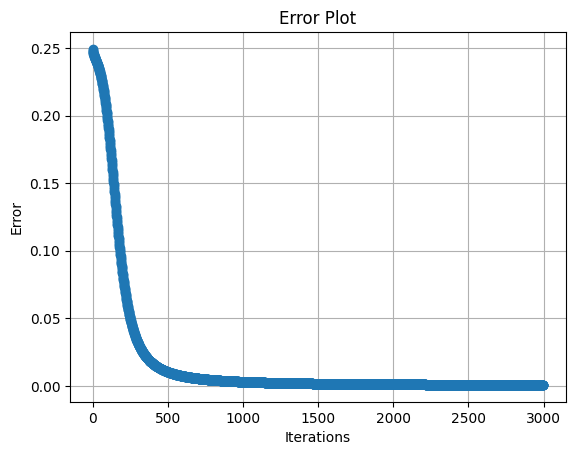

In [18]:
# Plotting the errors
plt.plot(Error, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error Plot')
plt.grid(True)
plt.show()